# 模式识别大作业之集成学习

**作者：RanShareCo**

本次实验做的是回归任务，使用的数据集是kaggle平台的housing pricing数据集，训练集1460个样本，测试集1459个样本，总特征80个。

对于该数据在特征工程上花费了较大的功夫。

在模型构建上我最开始使用简单linear regression发现对于该数据完全无法正常拟合，改用其他正则化线性模型Lasso、Ridge、Elastic Net，结果突然就变得好起来了，其原理也有在文档里进行介绍，最后将多个线性模型使用**加权平均策略**进行集成。

在此基础上还尝试了使用我们学过的SVM来做回归，sklearn里面称为**SVR**，结果也还不错，因此考虑作为**bagging的基学习器**。

最后根据本次上机的重点内容为**集成学习**，使用Bagging和Boosting家族的典型模型，**Adaboost，RandomForest，XGBoost，LightGBM**。

其原理也在文档中有所记录，最终是通过加权平均来得到最后的结果并上传到kaggle上，排名略低。

## 第一步加载数据

In [1]:
import pandas as pd
import numpy as np 

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 特征观察

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**先验知识**：衡量正态分布的两个指标 **峰度** 和 **偏度**
- 峰度(Kurtosis):峰度衡量数据分布的平坦度（flatness）。尾部大的数据分布，其峰度值较大。
$$K = \frac{\frac{1}{n}\sum_{i=1}^n(x_i - \overline{x})^4}{(\frac{1}{n}\sum_{i=1}^n(x_i - \overline{x})^2)^2}$$
- 偏态(Skewness):偏态量度对称性。0说明是最完美的对称性，正态分布的偏态就是0。如图2所示，右偏态为正，表明平均值大于中位数。反之为左偏态，为负。
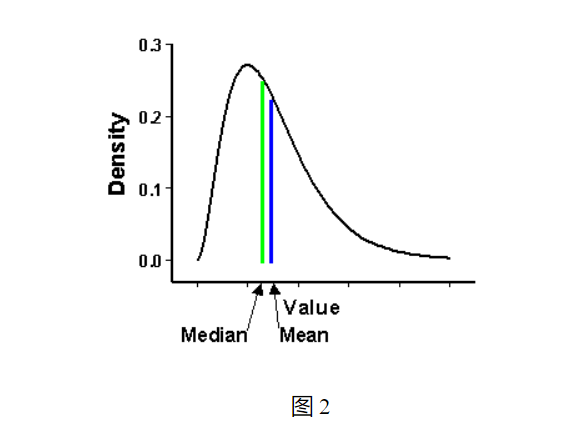
$$S = \frac{\frac{1}{n}\sum_{i=1}^n(x_i - \overline{x})^3}{(\frac{1}{n}\sum_{i=1}^n(x_i - \overline{x})^2)^{\frac{3}{2}}}$$

这里需要将因变量转化为正态分布的解释：
- 在现实数据中，基于统计学理论，我们假设大多数线性回归的噪声都符合正态分布，这种假设能够满足最小二乘估计和概率极大似然估计是等价的，而因变量保证正态分布，则有利于保证误差的正态性
- 对于线性回归模型,当因变量服从正态分布,误差项满足高斯–马尔科夫条件（零均值、等方差、不相关）时,回归参数的最小二乘估计是一致最小方差无偏估计.

E:\Anaconda\envs\mlearning\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


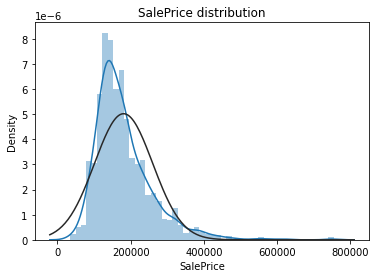

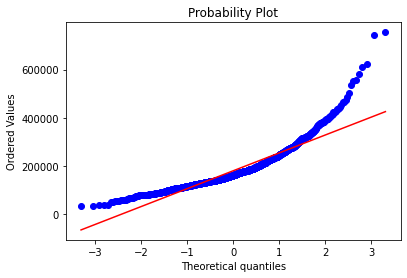

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


In [8]:
# 房价分布情况
from scipy import stats
from scipy.stats import norm,skew
sns.distplot(train_data['SalePrice'] , fit=norm)#与高斯分布对比
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

print("Skewness: " ,train_data['SalePrice'].skew()) #偏度
print("Kurtosis: " ,train_data['SalePrice'].kurt()) #峰度

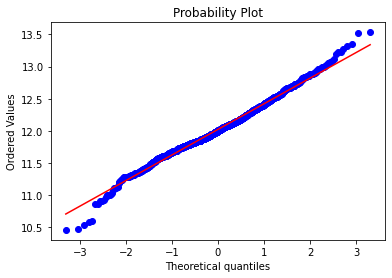

In [9]:
# 测试适合的变换，box-cox的详细介绍在后面
from scipy.special import boxcox1p
lam = 0
data = boxcox1p(train_data["SalePrice"], lam)
fig = plt.figure()
res = stats.probplot(data, plot=plt)
plt.show()
# 最优为对数变换

E:\Anaconda\envs\mlearning\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


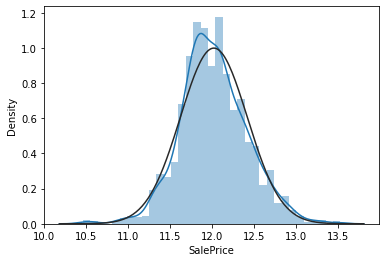

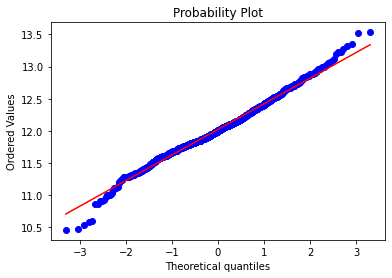

In [10]:
# 可见价格右偏，使用对数矫正
train_data["SalePrice"] = np.log(train_data["SalePrice"])

sns.distplot(train_data['SalePrice'] , fit=norm)

fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

In [11]:
# 删除id无效特征
train_id = train_data['Id'].values
test_id = test_data['Id'].values
train_data.drop('Id',axis=1,inplace=True)
test_data.drop('Id',axis=1,inplace=True)

In [12]:
train_data.shape,test_data.shape

((1460, 80), (1459, 79))

## 相关性分析

<AxesSubplot:>

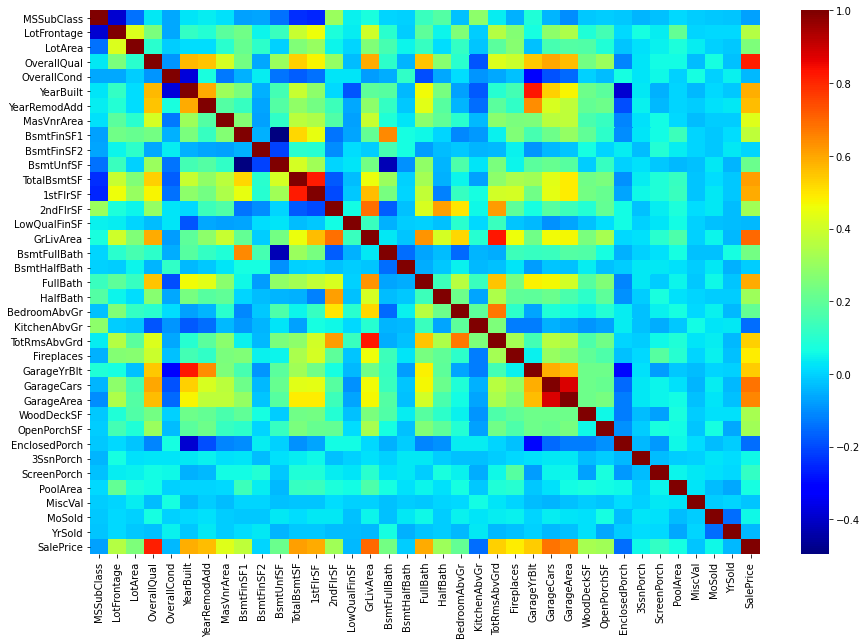

In [13]:
# 画出相关系数图像
corrmat = train_data.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corrmat,cmap='jet')

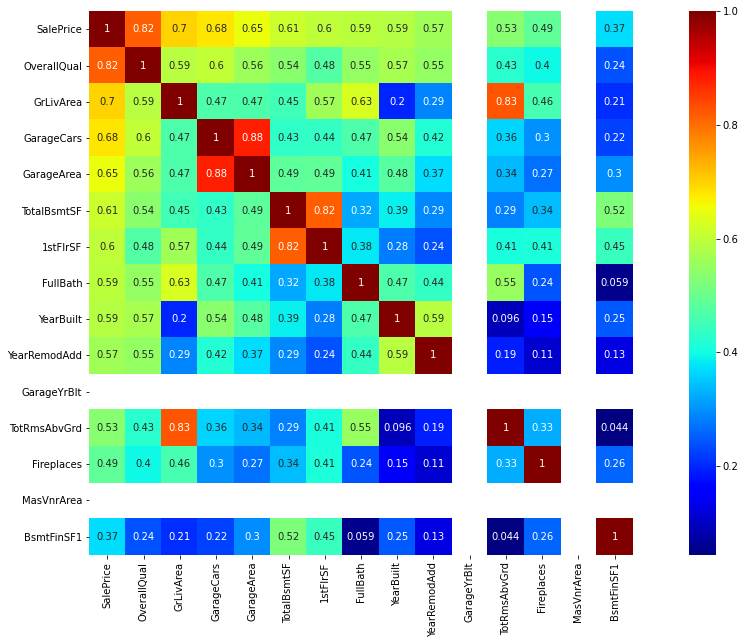

In [14]:
k = 15
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
#nlargest可以用于找到列表中最大的前k个元素
cm = np.corrcoef(train_data[cols].values.T)
fg,ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm,annot=True, square=True,ax=ax,xticklabels=cols.values,yticklabels=cols.values,cmap='jet')
plt.show()

## 处理缺失值

In [15]:
# 查看缺失值情况
pd.set_option('display.max_rows',100)
#print((train_data.isnull().sum()/train_data.shape[0]*100).sort_values(ascending=False))
#print((train_data.isnull().sum()).sort_values(ascending=False))
na_data_train = (train_data.isnull().sum()/train_data.shape[0]*100).sort_values(ascending=False)[:20]
na_data_train.head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
MSSubClass       0.000000
dtype: float64

In [16]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False #显示负号

Text(0.5, 1.0, '训练集缺失情况')

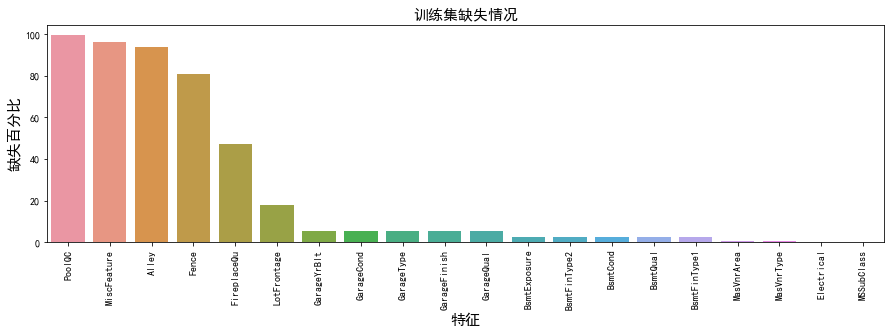

In [17]:
f, ax = plt.subplots(figsize=(15,4 ))
plt.xticks(rotation='90')
sns.barplot(x=na_data_train.index, y=na_data_train)
plt.xlabel('特征', fontsize=15)
plt.ylabel('缺失百分比', fontsize=15)
plt.title('训练集缺失情况', fontsize=15)

In [18]:
na_data_test = (test_data.isnull().sum()/test_data.shape[0]*100).sort_values(ascending=False)[:20]
na_data_test.head(20)

PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageYrBlt      5.346127
GarageFinish     5.346127
GarageQual       5.346127
GarageCond       5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType2     2.878684
BsmtFinType1     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
Functional       0.137080
dtype: float64

Text(0.5, 1.0, '测试集缺失情况')

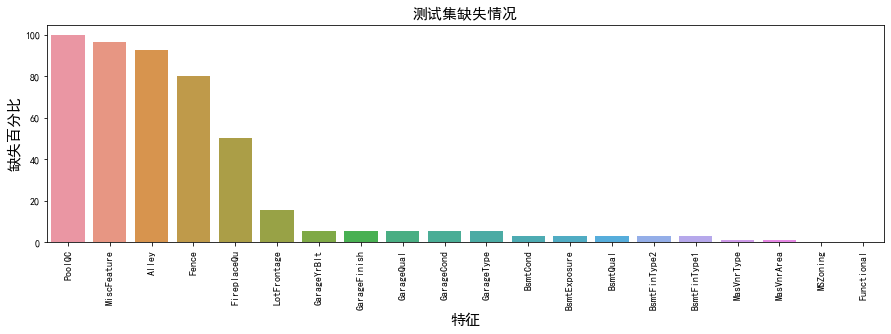

In [19]:
f, ax = plt.subplots(figsize=(15,4 ))
plt.xticks(rotation='90')
sns.barplot(x=na_data_test.index, y=na_data_test)
plt.xlabel('特征', fontsize=15)
plt.ylabel('缺失百分比', fontsize=15)
plt.title('测试集缺失情况', fontsize=15)

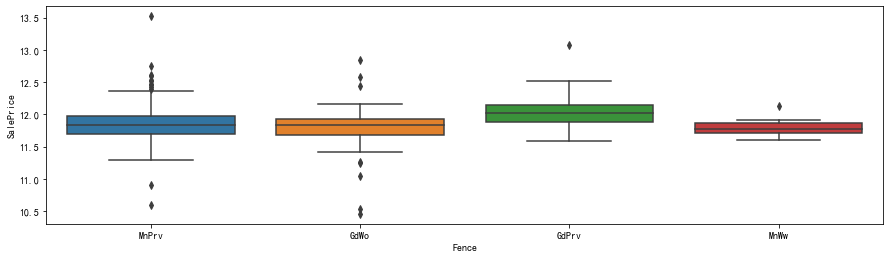

In [20]:
''' 分析离散特征相关性 '''
def analyse_disperse(feature1,feature2):
    f, ax = plt.subplots(figsize=(15,4 ))
    sns.boxplot(x=feature1,y=feature2)
    plt.show()
analyse_disperse(train_data['Fence'],train_data['SalePrice'])

### 由于PoolQC，MiscFeature，Alley，Fence四个特征缺失情况严重，同时与价格的相关性较差，可以直接丢弃           

In [21]:
drop_feature =['PoolQC','MiscFeature','Alley','Fence']
train_data.drop(drop_feature,axis=1,inplace=True)
test_data.drop(drop_feature,axis=1,inplace=True)
train_data.shape,test_data.shape

((1460, 76), (1459, 75))

In [22]:
# 查看剩下缺失值数据情况
pd.set_option('display.max_rows',100)
na_data_new = (train_data.isnull().sum()/train_data.shape[0]*100).sort_values(ascending=False)[:20]
na_data_new.head(20)

FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
Fireplaces       0.000000
KitchenQual      0.000000
KitchenAbvGr     0.000000
BedroomAbvGr     0.000000
HalfBath         0.000000
dtype: float64

In [23]:
# 查看剩下缺失值数据情况
pd.set_option('display.max_rows',100)
na_data_new = (test_data.isnull().sum()/test_data.shape[0]*100).sort_values(ascending=False)[:20]
na_data_new.head(20)

FireplaceQu     50.034270
LotFrontage     15.558602
GarageQual       5.346127
GarageFinish     5.346127
GarageCond       5.346127
GarageYrBlt      5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtHalfBath     0.137080
Functional       0.137080
BsmtFullBath     0.137080
Utilities        0.137080
GarageCars       0.068540
dtype: float64

### FireplaceQu 代表壁炉质量,缺失就是没有壁炉直接填None

In [24]:
train_data["FireplaceQu"] = train_data["FireplaceQu"].fillna("None")
test_data["FireplaceQu"] = test_data["FireplaceQu"].fillna("None")

### LotFrontage 代表距离街道的直线距离，可以根据同一个市区房子的数据中位数来填补

In [25]:
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### GarageType GarageYrBlt GarageFinish GarageQual GarageCond 都是一些车库的琐碎情况
从上面相关性分析可以知道其主要作用的是 GarageArea，GarageCars，因此直接填充None和0便可

In [26]:
for feature in ('GarageType', 'GarageFinish' ,'GarageQual','GarageCond'):
    train_data[feature].fillna('None',inplace=True)
    test_data[feature].fillna('None',inplace=True)
train_data['GarageYrBlt'].fillna(0,inplace=True)
test_data['GarageYrBlt'].fillna(0,inplace=True)

### BsmtExposure BsmtQual BsmtCond BsmtFinType1 BsmtFinType2 BsmtHalfBath BsmtFullBath 是地下室的一些情况
从上面相关性分析可以知道其主要作用的是 TotalBsmtSF 地下室总面积，这里缺失值可以认为是没有地下室

In [27]:
for feature in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_data[feature].fillna('None',inplace=True)
    test_data[feature].fillna('None',inplace=True)
for feature in ('BsmtFinSF1', 'BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath'):
    train_data[feature].fillna(0,inplace=True)
    test_data[feature].fillna(0,inplace=True)

### Mas为砖石结构相关变量，缺失值我们同样认为是没有砖石结构，用0和none填补缺失值

In [28]:
train_data["MasVnrType"].fillna("None",inplace=True)
train_data["MasVnrArea"].fillna(0,inplace=True)
test_data["MasVnrType"].fillna("None",inplace=True)
test_data["MasVnrArea"].fillna(0,inplace=True)

### Electrical为电力系统，这里通过分析可以知道一个地区所使用电力系统基本一致，因此用同地区的电力系统来代替缺失值

In [29]:
from collections import Counter
l = list(train_data.groupby('Neighborhood')['Electrical'])
for i,g in l:
    print(Counter(g))

Counter({'SBrkr': 17})
Counter({'SBrkr': 2})
Counter({'SBrkr': 16})
Counter({'SBrkr': 42, 'FuseA': 13, 'FuseF': 3})
Counter({'SBrkr': 25, 'FuseA': 2, 'FuseF': 1})
Counter({'SBrkr': 150})
Counter({'SBrkr': 46, 'FuseA': 3, 'FuseF': 2})
Counter({'SBrkr': 78, 'FuseA': 12, 'FuseF': 9, 'FuseP': 1})
Counter({'SBrkr': 79})
Counter({'SBrkr': 22, 'FuseA': 10, 'FuseF': 4, 'Mix': 1})
Counter({'SBrkr': 17})
Counter({'SBrkr': 48, 'FuseA': 1})
Counter({'SBrkr': 195, 'FuseA': 27, 'FuseF': 3})
Counter({'SBrkr': 9})
Counter({'SBrkr': 73})
Counter({'SBrkr': 41})
Counter({'SBrkr': 77})
Counter({'SBrkr': 87, 'FuseA': 21, 'FuseF': 3, 'FuseP': 2})
Counter({'SBrkr': 20, 'FuseA': 3, 'FuseF': 2})
Counter({'SBrkr': 74})
Counter({'SBrkr': 58, 'FuseA': 1})
Counter({'SBrkr': 86})
Counter({'SBrkr': 25})
Counter({'SBrkr': 36, 'FuseA': 1, nan: 1})
Counter({'SBrkr': 11})


In [30]:
train_data['Electrical'] = train_data.groupby('Neighborhood')['Electrical'].transform(lambda x:x.fillna(Counter(x).most_common(1)[0][0]))
test_data['Electrical'] = test_data.groupby('Neighborhood')['Electrical'].transform(lambda x:x.fillna(Counter(x).most_common(1)[0][0]))

In [31]:
# 查看剩下缺失值数据情况
pd.set_option('display.max_rows',100)
na_data_new = (test_data.isnull().sum()/test_data.shape[0]*100).sort_values(ascending=False)[:20]
na_data_new.head(20)

MSZoning        0.27416
Utilities       0.13708
Functional      0.13708
Exterior2nd     0.06854
SaleType        0.06854
Exterior1st     0.06854
TotalBsmtSF     0.06854
BsmtUnfSF       0.06854
GarageCars      0.06854
GarageArea      0.06854
KitchenQual     0.06854
KitchenAbvGr    0.00000
Fireplaces      0.00000
TotRmsAbvGrd    0.00000
MSSubClass      0.00000
BedroomAbvGr    0.00000
HalfBath        0.00000
FireplaceQu     0.00000
BsmtHalfBath    0.00000
BsmtFullBath    0.00000
dtype: float64

In [32]:
select = ['GarageYrBlt','MSZoning','Utilities','Functional','Exterior2nd','SaleType','Exterior1st',
         'TotalBsmtSF','BsmtUnfSF','GarageCars','GarageArea','KitchenQual']
for i in select:
    print(i)
    print(Counter(test_data[i]))

GarageYrBlt
Counter({0.0: 78, 2005.0: 77, 2007.0: 66, 2006.0: 56, 2004.0: 46, 2003.0: 42, 2008.0: 32, 1977.0: 31, 2000.0: 28, 1998.0: 27, 1993.0: 27, 2002.0: 27, 1950.0: 27, 1997.0: 25, 1956.0: 25, 1999.0: 24, 1978.0: 22, 1968.0: 22, 1958.0: 21, 1967.0: 21, 1994.0: 21, 1976.0: 21, 2001.0: 21, 1979.0: 20, 1996.0: 20, 1975.0: 19, 1920.0: 19, 1959.0: 19, 1930.0: 19, 1961.0: 18, 1966.0: 18, 1960.0: 18, 1963.0: 18, 1954.0: 18, 1974.0: 17, 1964.0: 17, 1969.0: 17, 1995.0: 17, 1980.0: 17, 1973.0: 15, 1992.0: 14, 1957.0: 14, 1962.0: 14, 1952.0: 13, 1965.0: 13, 1972.0: 13, 1970.0: 12, 1939.0: 12, 1971.0: 11, 1955.0: 11, 1940.0: 11, 1951.0: 11, 1984.0: 11, 1953.0: 11, 1990.0: 10, 1989.0: 9, 1926.0: 9, 2009.0: 8, 1938.0: 8, 1948.0: 8, 1985.0: 8, 1991.0: 8, 1910.0: 7, 1987.0: 7, 1949.0: 6, 1945.0: 6, 1986.0: 6, 1988.0: 6, 1900.0: 5, 1915.0: 5, 1981.0: 5, 1982.0: 5, 1924.0: 5, 1946.0: 5, 1925.0: 5, 1942.0: 4, 1941.0: 4, 1927.0: 4, 1983.0: 4, 1937.0: 4, 1935.0: 4, 1928.0: 3, 1923.0: 3, 1947.0: 3, 192

In [33]:
test_data["MSZoning"].fillna(test_data['MSZoning'].mode()[0],inplace=True)
train_data.drop('Utilities',axis=1,inplace=True)
test_data.drop('Utilities',axis=1,inplace=True)
test_data["Functional"] = test_data["Functional"].fillna("Typ")
test_data['Exterior1st'] = test_data['Exterior1st'].fillna(test_data['Exterior1st'].mode()[0])
test_data['Exterior2nd'] = test_data['Exterior2nd'].fillna(test_data['Exterior2nd'].mode()[0])
test_data['SaleType'] = test_data['SaleType'].fillna(test_data['SaleType'].mode()[0])
test_data['TotalBsmtSF'].fillna(0,inplace=True)
test_data['BsmtUnfSF'].fillna(0,inplace=True)
test_data['KitchenQual'].fillna('TA',inplace=True)
test_data['GarageCars'].fillna(0,inplace=True)
test_data['GarageArea'].fillna(0,inplace=True)

## 特征工程 

根据上面热力图的相关性显示，与价格相关性较强的特征包括：
OverallQual、GrLivArea、GarageCars、GarageArea、TotalBsmtSF、1stFlrSF、FullBath、TotRmsAbvGrd、YearBuilt、YearRemodAdd

### 从面积角度分析

观察各面积属性的相关性

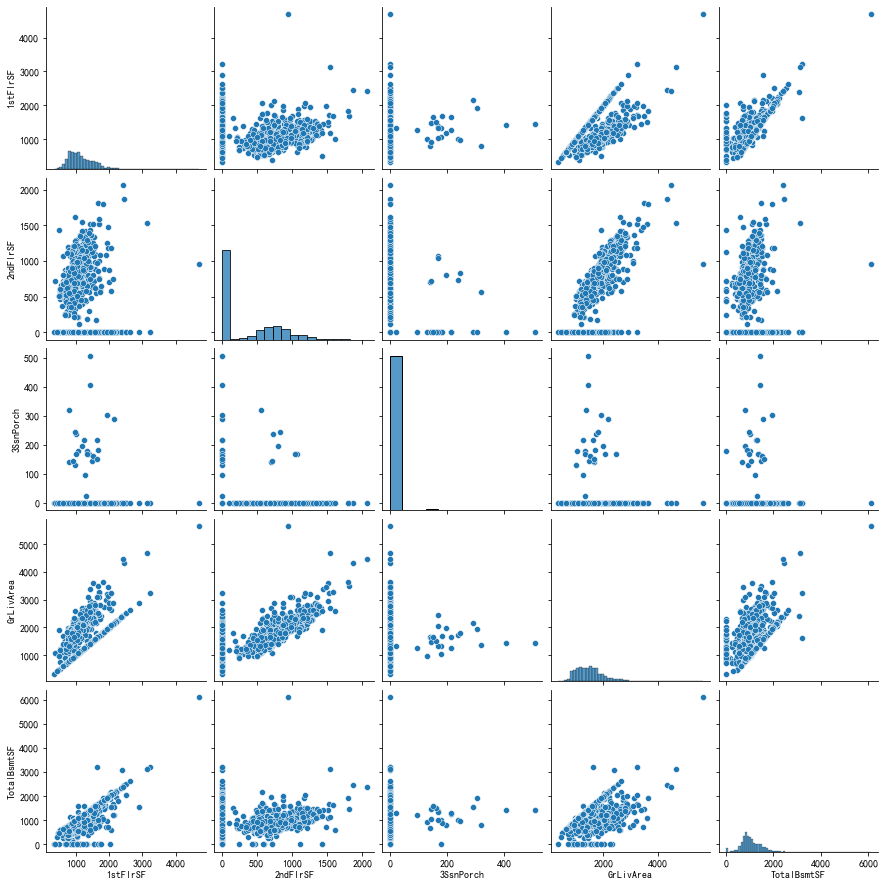

In [34]:
select = ['1stFlrSF','2ndFlrSF','3SsnPorch','GrLivArea','TotalBsmtSF']
sns.pairplot(train_data[select])

In [35]:
Counter(train_data['3SsnPorch'])

Counter({0: 1436,
         320: 1,
         407: 1,
         130: 1,
         180: 2,
         168: 3,
         140: 1,
         508: 1,
         238: 1,
         245: 1,
         196: 1,
         144: 2,
         182: 1,
         162: 1,
         23: 1,
         216: 2,
         96: 1,
         153: 1,
         290: 1,
         304: 1})

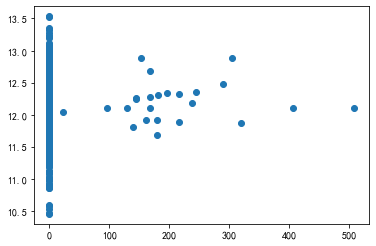

In [36]:
plt.scatter(x = train_data['3SsnPorch'],y = train_data['SalePrice'])

可见除了门廊面缺乏数据情况严重，可直接去除，其他面积间具有相关性，因此可以合并为一个特征

In [37]:
train_data.drop('3SsnPorch',axis=1,inplace=True)
test_data.drop('3SsnPorch',axis=1,inplace=True)

观察各面积属性与价格的相关性

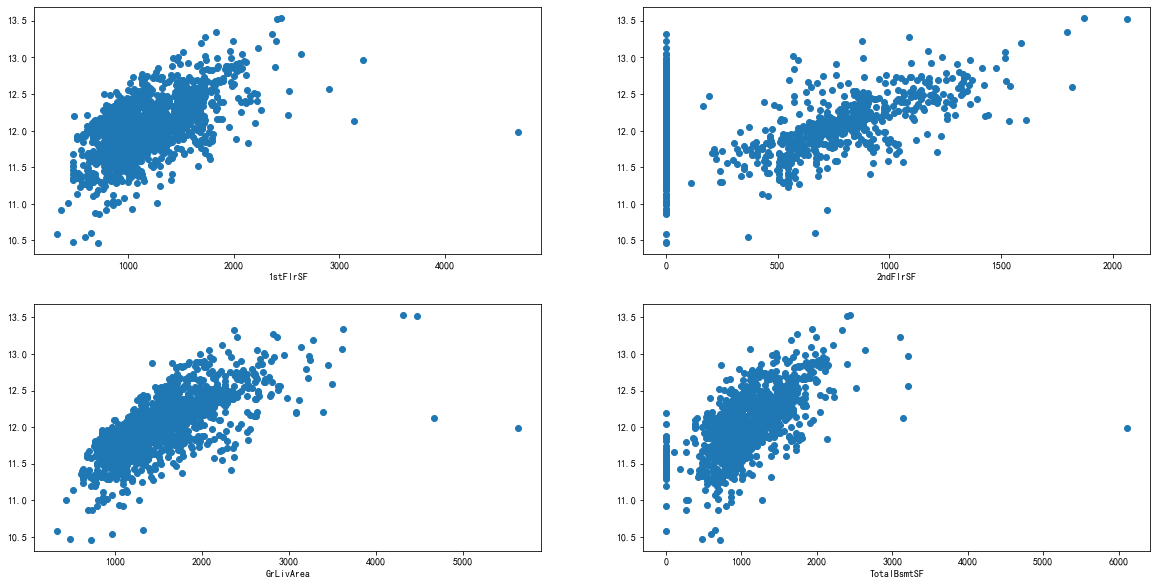

In [38]:
select = ['1stFlrSF','2ndFlrSF','GrLivArea','TotalBsmtSF']
fig,axs = plt.subplots(2,2,figsize=(20,10))
ax = axs.flatten()
for i,feature in enumerate(select):
#     plt.subplots(2,2,i+1,figsize=(12,10))
    ax[i].scatter(x=train_data[feature],y=train_data['SalePrice'])
    ax[i].set_xlabel(feature)
plt.show()

去除离群点

In [39]:
# 去除异常值
train_data.drop(train_data[(train_data['1stFlrSF']>4000)&(train_data['SalePrice']<12.5)].index,inplace=True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>4000)&(train_data['SalePrice']<12.5)].index,inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000)&(train_data['SalePrice']<12.5)].index,inplace=True)

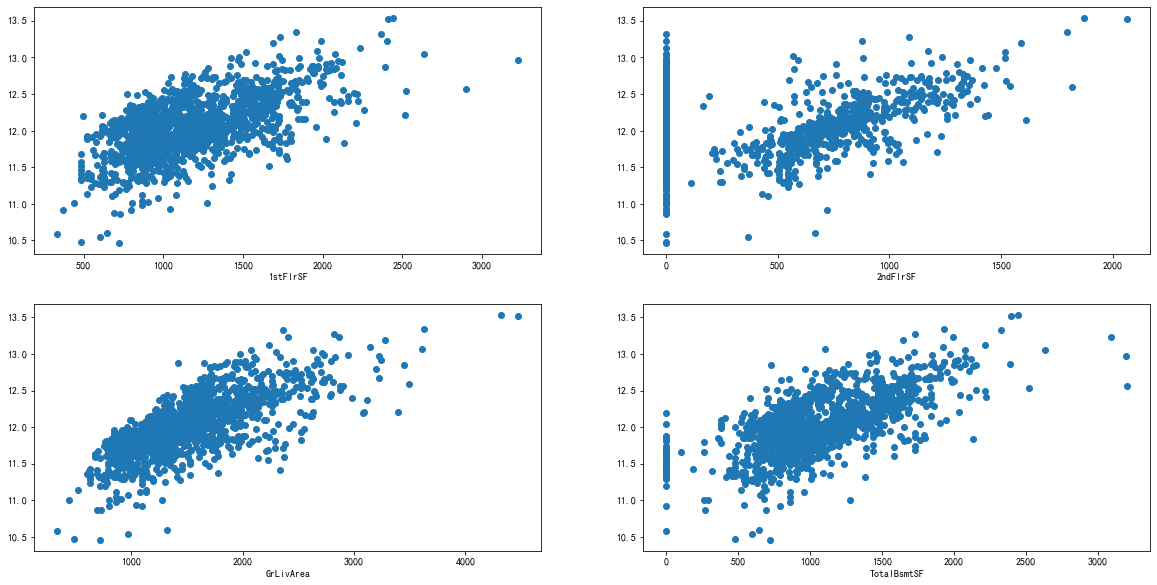

In [40]:
select = ['1stFlrSF','2ndFlrSF','GrLivArea','TotalBsmtSF']
fig,axs = plt.subplots(2,2,figsize=(20,10))
ax = axs.flatten()
for i,feature in enumerate(select):
#     plt.subplots(2,2,i+1,figsize=(12,10))
    ax[i].scatter(x=train_data[feature],y=train_data['SalePrice'])
    ax[i].set_xlabel(feature)
plt.show()

添加新特征：总面积

In [41]:
train_data['TotalSF'] = train_data['1stFlrSF']+train_data['2ndFlrSF']+train_data['GrLivArea']+train_data['TotalBsmtSF']
test_data['TotalSF'] = test_data['1stFlrSF']+test_data['2ndFlrSF']+test_data['GrLivArea']+test_data['TotalBsmtSF']

查看新特征与价格的关系

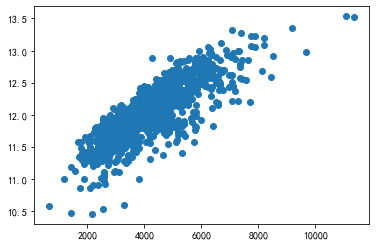

In [42]:
plt.scatter(x=train_data['TotalSF'],y=train_data['SalePrice'])

具有较强相关性，是一个好特征

### 从车库角度出发

起关键作用的是GarageCars和GarageArea

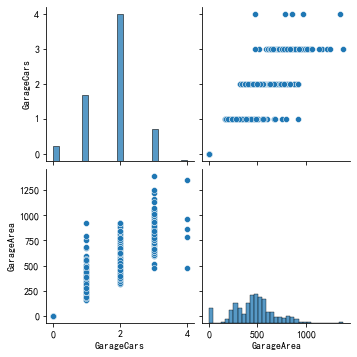

In [43]:
select = ['GarageCars','GarageArea']
sns.pairplot(data=train_data[select])

<AxesSubplot:>

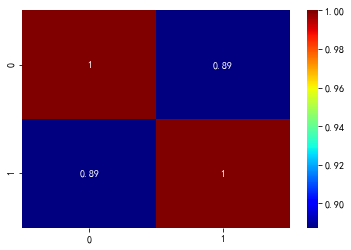

In [44]:
cor = np.corrcoef(train_data[select].values.T)
sns.heatmap(data=cor,annot=True,cmap='jet')

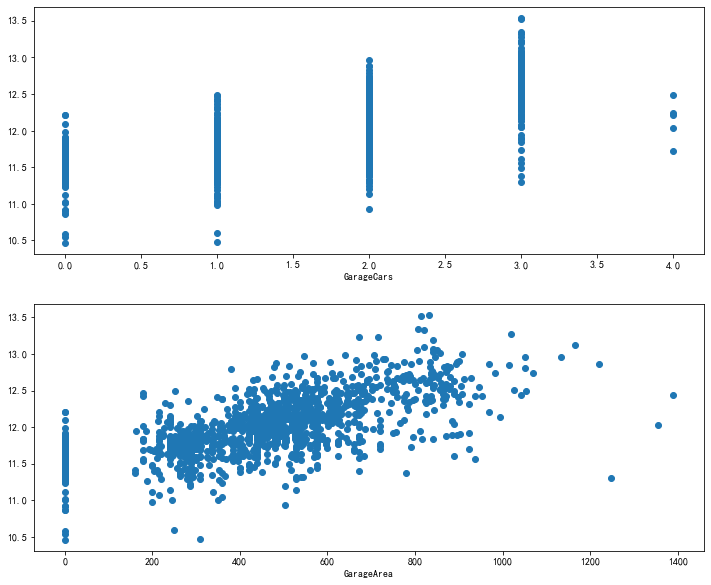

In [45]:
fig,axs = plt.subplots(2,1,figsize=(12,10))
ax = axs.flatten()
for i,feature in enumerate(select):
    ax[i].scatter(x=train_data[feature],y=train_data['SalePrice'])
    ax[i].set_xlabel(feature)
plt.show()

In [46]:
train_data.drop(train_data[(train_data['GarageArea']>1200)&(train_data['SalePrice']<11.5)].index,inplace=True)

In [47]:
train_data['GarageTotal'] = train_data['GarageCars']*train_data['GarageArea']
test_data['GarageTotal'] = test_data['GarageCars']*test_data['GarageArea']

查看新特征与price的关系

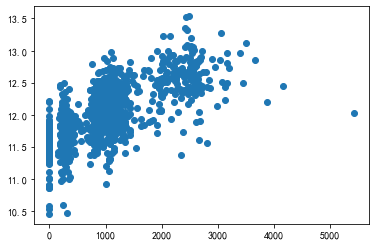

In [48]:
plt.scatter(x=train_data['GarageTotal'],y=train_data['SalePrice'])

去除离群点

In [49]:
train_data.drop(train_data[(train_data['GarageTotal']>5000)&(train_data['SalePrice']<12.5)].index,inplace=True)

### 考虑浴室情况

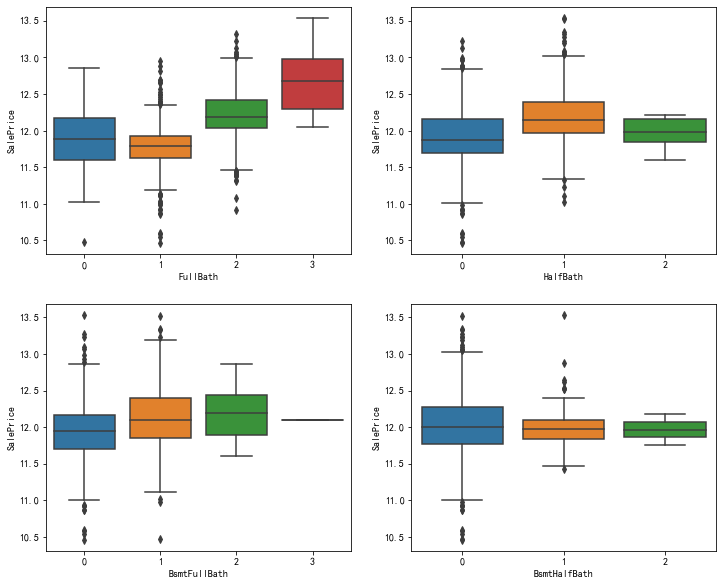

In [50]:
bath = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']
fig,axs = plt.subplots(2,2,figsize=(12,10))
ax = axs.flatten()
for i,feature in enumerate(bath):
#     ax[i].boxplot(x=train_data[feature],y=train_data['SalePrice'])
    sns.boxplot(x=train_data[feature],y=train_data['SalePrice'],ax=ax[i])
    ax[i].set_xlabel(feature)
plt.show()

In [51]:
train_data['Total_Bathrooms'] = (train_data['FullBath'] + (0.5 * train_data['HalfBath']) +
                               train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath']))
test_data['Total_Bathrooms'] = (test_data['FullBath'] + (0.5 * test_data['HalfBath']) +
                               test_data['BsmtFullBath'] + (0.5 * test_data['BsmtHalfBath']))

查看新特征与price的关系

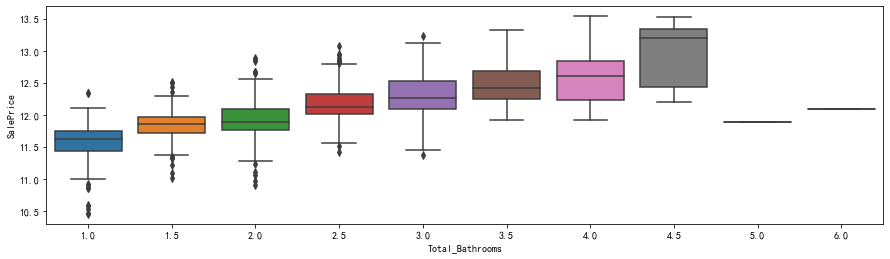

In [52]:
analyse_disperse(train_data['Total_Bathrooms'],train_data['SalePrice'])

In [53]:
train_data.drop(train_data[(train_data['Total_Bathrooms']>4.8)&(train_data['SalePrice']<12.5)].index,inplace=True)

In [54]:
SalePrice = train_data['SalePrice']
train_data.drop('SalePrice',axis=1,inplace=True)
SalePrice.head(5)

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [55]:
train_data.shape,test_data.shape

((1454, 76), (1459, 76))

## 数据编码

LabelEncoder:将数据按照数值进行编码(如：0，1，2，3，...)</br>
OneHotEncoder:使用m个数来对m类别进行编码


- 虚拟变量：直接在回归模型中加入定性因素（比如类别因素：男或女）存在困难，因此可以考虑把定性因素量化，使定性因素与定量因素在回归模型中起到相同的作用。这时就用到了虚拟变量。</br>
</br>
  对于定性因素性别而言，它有两个水平——男和女，可以用一个虚拟变量x表示，x=1表示男，x=0表示女</br>
  也可以用两个虚拟变量x和y表示，x=1表示是男，x=0表示不是男，同理y=1表示女，y=0表示不是女。</br>  
</br>
- 虚拟陷阱：引入虚拟变量后有可能出现多重共线性的问题，因此对于引入的虚拟变量的个数要做出一定约束
    - 当有截距项时，引入的虚拟变量只能是m-1个，其中m相互排斥属性个数</br>
    - 当无截距项时，可以引入m个</br>
    1 1 0        &emsp;&emsp;&emsp;&emsp;       1 0</br>
    1 0 1   含截距  &emsp;     1 0  不含截距项</br>
    1 1 0   不满秩  &emsp;      0 1  满秩</br>
    1 1 0         &emsp; &emsp;&emsp;&emsp;     1 0</br>
    1 0 1         &emsp;&emsp;&emsp; &emsp;      0 1</br>

### 合并数据

In [56]:
train_data_n = train_data.shape[0]
test_data_n = test_data.shape[0]
all_data = pd.concat((train_data,test_data)).reset_index(drop=True)

In [57]:
all_data.shape

(2913, 76)

In [58]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       2913 non-null   int64  
 1   MSZoning         2913 non-null   object 
 2   LotFrontage      2913 non-null   float64
 3   LotArea          2913 non-null   int64  
 4   Street           2913 non-null   object 
 5   LotShape         2913 non-null   object 
 6   LandContour      2913 non-null   object 
 7   LotConfig        2913 non-null   object 
 8   LandSlope        2913 non-null   object 
 9   Neighborhood     2913 non-null   object 
 10  Condition1       2913 non-null   object 
 11  Condition2       2913 non-null   object 
 12  BldgType         2913 non-null   object 
 13  HouseStyle       2913 non-null   object 
 14  OverallQual      2913 non-null   int64  
 15  OverallCond      2913 non-null   int64  
 16  YearBuilt        2913 non-null   int64  
 17  YearRemodAdd  

In [59]:
for i in all_data.dtypes[all_data.dtypes == 'int64'].index:
        print(i,all_data[i].dtypes)
        print(Counter(all_data[i]))

MSSubClass int64
Counter({20: 1079, 60: 573, 50: 287, 120: 182, 30: 138, 70: 128, 160: 128, 80: 118, 90: 107, 190: 60, 85: 48, 75: 23, 45: 18, 180: 17, 40: 6, 150: 1})
LotArea int64
Counter({9600: 44, 7200: 43, 6000: 34, 9000: 29, 10800: 24, 7500: 21, 8400: 21, 6240: 18, 1680: 18, 6120: 17, 7000: 13, 9100: 12, 8125: 12, 9750: 12, 10400: 11, 5400: 10, 8640: 10, 8000: 10, 8450: 9, 2280: 9, 5000: 9, 9900: 9, 8750: 9, 10000: 9, 3182: 8, 7800: 8, 10320: 8, 11250: 7, 10200: 7, 10625: 7, 9350: 7, 11700: 7, 10140: 7, 4435: 7, 8800: 7, 13072: 6, 9375: 6, 4500: 6, 7018: 6, 8520: 6, 8250: 6, 1890: 6, 3675: 6, 6600: 6, 11050: 6, 8544: 5, 10440: 5, 7750: 5, 8760: 5, 10530: 5, 7875: 5, 8064: 5, 11500: 5, 10237: 5, 8500: 4, 9200: 4, 2645: 4, 11645: 4, 9525: 4, 10500: 4, 2522: 4, 13891: 4, 2117: 4, 9060: 4, 10410: 4, 10125: 4, 12090: 4, 8012: 4, 7175: 4, 9571: 4, 6762: 4, 8480: 4, 13125: 4, 5925: 4, 2665: 4, 2308: 4, 11000: 4, 8777: 4, 7700: 4, 4426: 4, 8712: 4, 8172: 4, 4800: 4, 2544: 4, 3180: 4, 117

### 分析int64型数据

#### 数值取值范围不大数据转字符

In [60]:
select=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces']
for feature in select:
    print(Counter(all_data[feature]))
    all_data[feature]=all_data[feature].astype(str)

Counter({0.0: 1706, 1.0: 1170, 2.0: 36, 3.0: 1})
Counter({0.0: 2738, 1.0: 171, 2.0: 4})
Counter({2: 1528, 1: 1307, 3: 62, 0: 12, 4: 4})
Counter({0: 1831, 1: 1058, 2: 24})
Counter({3: 1592, 2: 741, 4: 399, 1: 103, 5: 48, 6: 21, 0: 8, 8: 1})
Counter({1: 2780, 2: 128, 0: 3, 3: 2})
Counter({6: 843, 7: 648, 5: 582, 8: 347, 4: 196, 9: 142, 10: 80, 11: 31, 3: 25, 12: 15, 2: 1, 14: 1, 13: 1, 15: 1})
Counter({0: 1417, 1: 1266, 2: 219, 3: 10, 4: 1})


#### 取值范围大但是无序的数值进行label编码

In [61]:
from sklearn.preprocessing import LabelEncoder
select=['YearBuilt','YearRemodAdd','MoSold','YrSold','MSSubClass','OverallQual','OverallCond']
for feature in select:
    encoder = LabelEncoder()
    all_data[feature] = encoder.fit_transform(list(all_data[feature].values))

#### 去除某些0值较多且无用的特征

In [62]:
all_data.drop('PoolArea',axis=1,inplace=True)
all_data.drop('MiscVal',axis=1,inplace=True)

### 分析object型数据

In [63]:
from sklearn.preprocessing import LabelEncoder
select = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir']
for feature in select:
    encoder = LabelEncoder()
    all_data[feature] = encoder.fit_transform(list(all_data[feature].values))

In [64]:
print(all_data.shape)

(2913, 74)


In [65]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       2913 non-null   int64  
 1   MSZoning         2913 non-null   object 
 2   LotFrontage      2913 non-null   float64
 3   LotArea          2913 non-null   int64  
 4   Street           2913 non-null   int64  
 5   LotShape         2913 non-null   int64  
 6   LandContour      2913 non-null   object 
 7   LotConfig        2913 non-null   object 
 8   LandSlope        2913 non-null   int64  
 9   Neighborhood     2913 non-null   object 
 10  Condition1       2913 non-null   object 
 11  Condition2       2913 non-null   object 
 12  BldgType         2913 non-null   object 
 13  HouseStyle       2913 non-null   object 
 14  OverallQual      2913 non-null   int64  
 15  OverallCond      2913 non-null   int64  
 16  YearBuilt        2913 non-null   int64  
 17  YearRemodAdd  

### 对数值型数据进行变换修正偏度

In [66]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
LotArea,13.158460
LowQualFinSF,12.076090
LandSlope,4.991687
BsmtFinSF2,4.141222
EnclosedPorch,3.999248
ScreenPorch,3.941914
MasVnrArea,2.620028
OpenPorchSF,2.528008
WoodDeckSF,1.846480
GarageTotal,1.371187


查看有多少特征的偏度不符合正太分布，并进行转换，阈值为1.0

In [67]:
skewness = skewness[abs(skewness) > 1.0]
print("有{}个特征需要转换 ".format(skewness.shape[0]))

有47个特征需要转换 


Box-Cox变换</br>
- 变换公式:
    $$y^{(\lambda)}=
    \left\{\begin{matrix} 
    \frac{y^{\lambda}-1}{\lambda},\lambda \neq 0 \\
    log(y),\lambda=0 
    \end{matrix} 
    \right.$$
- 逆变换公式:
    $$y=
    \left\{\begin{matrix} 
    (1+\lambda y^{(\lambda)})\frac{1}{\lambda},\lambda \neq 0 \\
    exp(y^{(\lambda)}),\lambda=0 
    \end{matrix} 
    \right.$$

这里λ是一个待定变换参数。对不同的λ，所做的变换自然就不同。它包括了**对数变换（λ=0）**，**平方根变换（λ=1/2**）和**倒数变换（λ＝-１）** 等常用变换。那么怎么去确定呢，这里使用的方法是假设经过转换后的因变量就是服从正态分布的，然后画出关于λ的似然函数，似然函数值最大的时候λ的取值就是这里的值。

In [68]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [69]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
LowQualFinSF,8.734802
LandSlope,4.546519
ScreenPorch,2.974364
BsmtFinSF2,2.560743
EnclosedPorch,2.022041
MasVnrArea,0.636666
2ndFlrSF,0.327907
HeatingQC,0.287898
WoodDeckSF,0.224178
1stFlrSF,0.179920


### 将无序型离散变量转化为哑变量（one-hot编码）

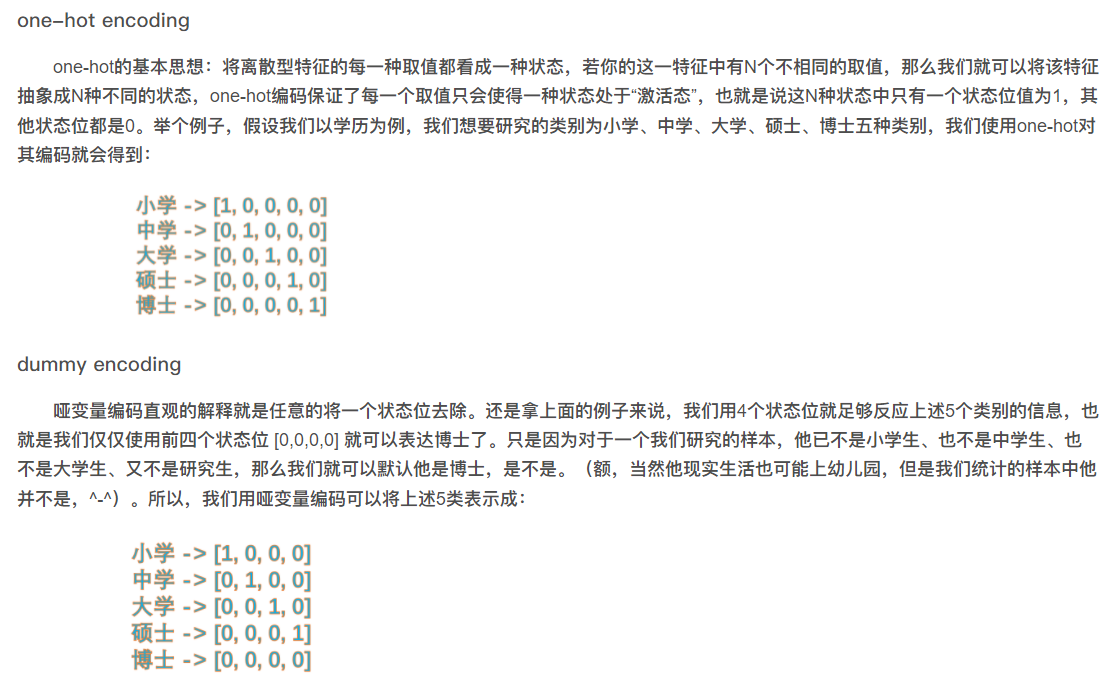

In [70]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       2913 non-null   float64
 1   MSZoning         2913 non-null   object 
 2   LotFrontage      2913 non-null   float64
 3   LotArea          2913 non-null   float64
 4   Street           2913 non-null   float64
 5   LotShape         2913 non-null   float64
 6   LandContour      2913 non-null   object 
 7   LotConfig        2913 non-null   object 
 8   LandSlope        2913 non-null   float64
 9   Neighborhood     2913 non-null   object 
 10  Condition1       2913 non-null   object 
 11  Condition2       2913 non-null   object 
 12  BldgType         2913 non-null   object 
 13  HouseStyle       2913 non-null   object 
 14  OverallQual      2913 non-null   float64
 15  OverallCond      2913 non-null   float64
 16  YearBuilt        2913 non-null   float64
 17  YearRemodAdd  

In [71]:
for i in all_data.dtypes[all_data.dtypes == "object"].index:
    print(i)
    print(Counter(all_data[i]))

MSZoning
Counter({'RL': 2264, 'RM': 460, 'FV': 139, 'RH': 26, 'C (all)': 24})
LandContour
Counter({'Lvl': 2620, 'HLS': 120, 'Bnk': 115, 'Low': 58})
LotConfig
Counter({'Inside': 2128, 'Corner': 510, 'CulDSac': 176, 'FR2': 85, 'FR3': 14})
Neighborhood
Counter({'NAmes': 443, 'CollgCr': 267, 'OldTown': 239, 'Edwards': 190, 'Somerst': 182, 'NridgHt': 166, 'Gilbert': 165, 'Sawyer': 151, 'NWAmes': 131, 'SawyerW': 125, 'Mitchel': 113, 'BrkSide': 108, 'Crawfor': 103, 'IDOTRR': 92, 'Timber': 72, 'NoRidge': 71, 'StoneBr': 51, 'SWISU': 48, 'ClearCr': 44, 'MeadowV': 37, 'BrDale': 30, 'Blmngtn': 28, 'Veenker': 24, 'NPkVill': 23, 'Blueste': 10})
Condition1
Counter({'Norm': 2508, 'Feedr': 162, 'Artery': 92, 'RRAn': 50, 'PosN': 38, 'RRAe': 28, 'PosA': 20, 'RRNn': 9, 'RRNe': 6})
Condition2
Counter({'Norm': 2884, 'Feedr': 13, 'Artery': 5, 'PosA': 4, 'PosN': 3, 'RRNn': 2, 'RRAn': 1, 'RRAe': 1})
BldgType
Counter({'1Fam': 2422, 'TwnhsE': 227, 'Duplex': 107, 'Twnhs': 96, '2fmCon': 61})
HouseStyle
Counter({'1

In [72]:
all_data = pd.get_dummies(all_data)

In [73]:
all_data.shape

(2913, 249)

In [74]:
all_data

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.055642,5.831328,19.212182,0.730463,1.540963,0.000000,2.259674,1.820334,6.844946,5.460736,...,0,0,0,1,0,0,0,0,1,0
1,0.000000,6.221214,19.712205,0.730463,1.540963,0.000000,2.055642,2.440268,6.291711,4.263161,...,0,0,0,1,0,0,0,0,1,0
2,2.055642,5.914940,20.347241,0.730463,0.000000,0.000000,2.259674,1.820334,6.808145,5.426781,...,0,0,0,1,0,0,0,0,1,0
3,2.259674,5.684507,19.691553,0.730463,0.000000,0.000000,2.259674,1.820334,4.201461,3.858807,...,0,0,0,1,1,0,0,0,0,0
4,2.055642,6.314735,21.325160,0.730463,0.000000,0.000000,2.440268,1.820334,6.789529,5.357203,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,3.237728,3.932510,14.081426,0.730463,1.540963,0.000000,1.540963,2.259674,6.148461,3.858807,...,0,0,0,1,0,0,0,0,1,0
2909,3.237728,3.932510,14.013314,0.730463,1.540963,0.000000,1.540963,1.820334,6.148461,3.858807,...,0,0,0,1,1,0,0,0,0,0
2910,0.000000,7.620056,22.782058,0.730463,1.540963,0.000000,1.820334,2.259674,5.887419,5.210789,...,0,0,0,1,1,0,0,0,0,0
2911,2.750250,5.744420,20.046557,0.730463,1.540963,0.000000,1.820334,1.820334,6.635082,5.053371,...,0,0,0,1,0,0,0,0,1,0


### 去除相关性较强的特征

(249, 249)


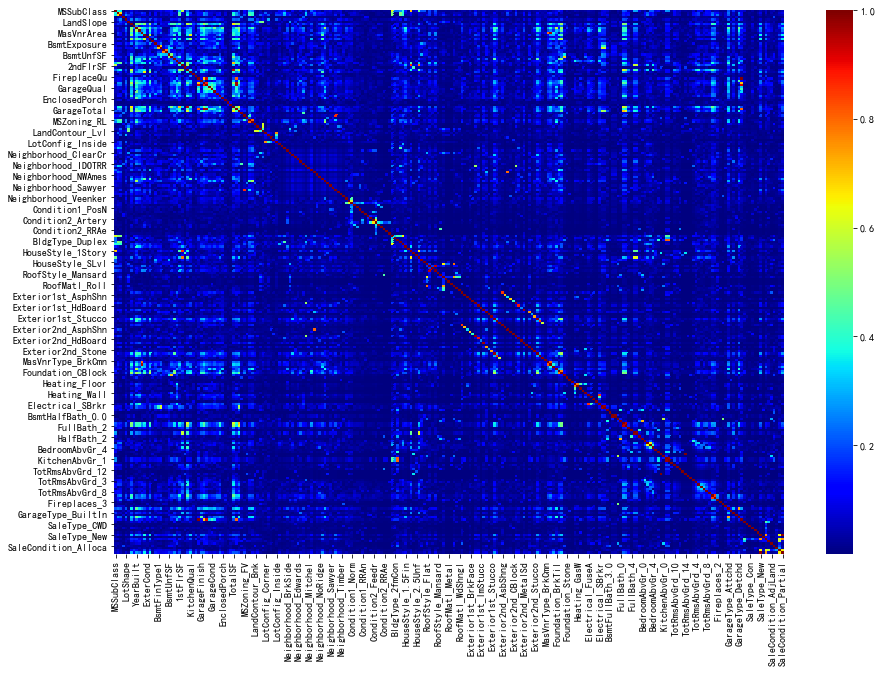

['GarageArea', 'TotalSF', 'GarageTotal', 'RoofStyle_Hip', 'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'MasVnrType_None', 'BsmtFullBath_1.0', 'BsmtHalfBath_1.0', 'FullBath_2', 'HalfBath_1', 'KitchenAbvGr_2', 'TotRmsAbvGrd_14', 'GarageType_None', 'SaleCondition_Partial']


In [75]:
shreshold = 0.9
corr_all_data = all_data.corr().abs()
# 取矩阵的上三角部分，判断系数大于0.9的并删除
data_up = corr_all_data.where(np.triu(np.ones(corr_all_data.shape), k=1).astype(np.bool))
print(data_up.shape)
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr_all_data,cmap='jet')
plt.show()
drop_col = [ column for column in data_up.columns if any(data_up[column] > 0.9)]
print(drop_col)

In [76]:
all_data = all_data.drop(columns=drop_col)

In [77]:
all_data.shape    # (1454, 368)

(2913, 233)

## 训练模型

### 数据

In [78]:
x_train = all_data[:train_data_n]
x_test = all_data[train_data_n:]
y_train = SalePrice.values

### 交叉验证&网格搜索

**交叉验证**：是将训练集数据划分为新的训练子集和验证集，通过训练集训练，验证集对模型进行评估。</br>

这里我们使用的是最常用的**“k折交叉验证”(k-fold cross validation)**:即将训练集随机抽取生成k份，取其中的一份为验证集，其余为新的训练子集。</br>
[cross_val_score API](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val#sklearn.model_selection.cross_val_score)

**网格搜索**：是对模型预设多种超参数组合，进而通过评估得出最好的模型超参数组合</br>
[GridSearchCV API](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)

**评估度量**：
- 这里根据回归的任务，选择RMSE根均方误差为度量</br>
    [self-designed metrics API](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring)</br>
    - greater_is_better	输入的score_func为记分函数时，该值为True（默认值）；输入函数为损失函数时，该值为False；在后面这种情况中，得到的对象会对结果进行翻转，因为损失函数意味着函数值越小，拟合情况越好
    
- R2：描述模型没有捕获到的信息占真实标签总信息的比例
    - RSS(Residual sum of square)残差平方和
        $$ RSS = \sum{i=1}{m}(y_i - \hat y_i)^2$$
    - ESS(Explained sum of square)回归平方和
        $$ ESS = \sum{i=1}{m}(\hat y_i - \overline y_i)^2$$
    - TSS(Total sum of square)总离差平方和
        $$ TSS = \sum{i=1}{m}(y_i - \overline y_i)^2$$
    - R2_Score
        $$ R^2 = 1 - \frac{RSS}{TSS}$$
    有大多数资料有公式:
        $$ TSS = RSS + ESS$$
        但其成立有条件，因此在某些情况下$R^2$可能出现负数情况

In [80]:
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.metrics import make_scorer,mean_squared_error

In [81]:
# def RMSE(y_true,y_pred):
#     mse = np.square(y_true-y_pred)
#     return np.sqrt(mse)
# score = make_scorer(RMSE,greater_is_better=False)

In [82]:
# score = make_scorer(mean_squared_error)

In [83]:
def evaluate_model(n_fold,model):
    kfold = KFold(n_fold,shuffle=True,random_state=40).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model,x_train.values,y_train,scoring='neg_mean_squared_error',cv=kfold,verbose=3,n_jobs=-1))
    return(rmse)
def evaluate_model_r2(n_fold,model):
    kfold = KFold(n_fold,shuffle=True,random_state=40).get_n_splits(x_train.values)
    r2 = cross_val_score(model,x_train.values,y_train,scoring='r2',cv=kfold,verbose=3)
    return(r2)

In [84]:
def gridsearch(n_fold,model,param={}):
    kfold = KFold(n_fold,shuffle=True,random_state=40).get_n_splits(x_train.values)
    grid = GridSearchCV(estimator=model,param_grid=param,scoring='neg_mean_squared_error',cv=kfold,verbose=3,n_jobs=-1)
    grid.fit(x_train.values,y_train)
    print(np.sqrt(-grid.best_score_))
    print(grid.best_estimator_)
    print(grid.best_params_)
    
def gridsearch_r2(n_fold,model,param={}):
    kfold = KFold(n_fold,shuffle=True,random_state=40).get_n_splits(x_train.values)
    grid = GridSearchCV(estimator=model,param_grid=param,scoring='r2',cv=kfold,verbose=3)
    grid.fit(x_train.values,y_train)
    print(np.sqrt(-grid.best_score_))
    print(grid.best_params_)

### 考虑选线性模型

#### LinearRgression 

线性回归：
- 回归方程：
    $$\hat y = w_0+w_1 x_1+w_2 x_2+...+w_n x_n$$
- 代价函数：
    $$ Cost(W)= \frac{1}{m}\sum_{i=1}^{m}(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))^2$$
- 求解方法:
    - 正则化方程：
        $$ W = (X^TX)^{-1}X^Ty$$
     常用于数据量较小情况，当$X^TX$不可逆时，可以加入正则项
    - 梯度下降法[FG](a为learning rate)：
        $$ w_j = w_j - \frac{2a}{m}\sum_{i=1}^{m}x_j^i(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))$$
     除了FG外，还有SGD、Mini-Batch、SAG等梯度下降方法

**tip：**
- 损失函数（Loss Function ）是定义在单个样本上的，算的是一个样本的误差。</br>
- 代价函数（Cost Function ）是定义在整个训练集上的，是所有样本误差的平均，也就是损失函数的平均。</br>
- 目标函数（Object Function）定义为：最终需要优化的函数。等于经验风险+结构风险（也就是代价函数 + 正则化项）。代价函数最小化，降低经验风险，正则化项最小化降低</br>

`sklearn.linear_model.LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)`
- fit_intercept bool, default=True 偏置项</br>
- normalize bool, default=False 标准化</br>
[LinearRegression API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression)

In [85]:
from sklearn.linear_model import LinearRegression

In [204]:
linear = LinearRegression()
evaluate_model(10,linear)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


array([2.18605869e+05, 4.55881376e+07, 2.76623132e+07, 4.86766488e+08,
       4.01700907e+07, 1.14279594e+07, 1.69274823e+08, 2.28617329e+08,
       1.18169385e+07, 2.22510288e+07])

总结：简单但是不能防止过拟合，面对多特征数据形同虚设

#### 精确相关和高度相关

- 精确相关性：
    其描述了特征之间具有完全相关关系，会导致$X^TX$矩阵不可逆，使得最小二乘法失效
    $$ (X^TX)^{-1} = \frac{1}{|X^TX|}(X^TX)^* \rightarrow 除零错误$$
- 高度相关性：
    描述特征之间相关性较高但是不完全相关，会导致$|X^TX|$较少，对应权重分量过大的问题
    $$ (X^TX)^{-1} = \frac{1}{|X^TX|}(X^TX)^* \rightarrow W较大$$

L2、L1正则化能够很好的抑制这种现象：
- L2正则化
    $$(X^TX+aI)W = X^Ty$$
    相当于加入了正则项$aI$,使得$X^TX+aI$满秩可逆，也能使得某些权重趋近于0但不等于0
- L1正则化
    $$(X^TX)W = X^Ty \pm aI$$
    虽然不能从根本上解决精确相关问题，但是可以抑制其效果，同时某些权重允许为0，起到了特征选择的效果

#### Ridge正则化(又称L2正则化)

- 代价函数：
    $$ Cost(W)= \frac{1}{m}\sum_{i=1}^{m}(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))^2+\lambda \sum_{j=1}^n w_j^2$$
- 梯度下降：
    $$ w_j = w_j - \frac{2a}{m}\sum_{i=1}^{m}x_j^i(y_i-\hat y_{i_W}(x_1^i，x_2^i，...)) - 2a\lambda w_j$$
- 意义：
    将权重的大小进行限制，避免某些特征的权重过大，导致过拟合现象
    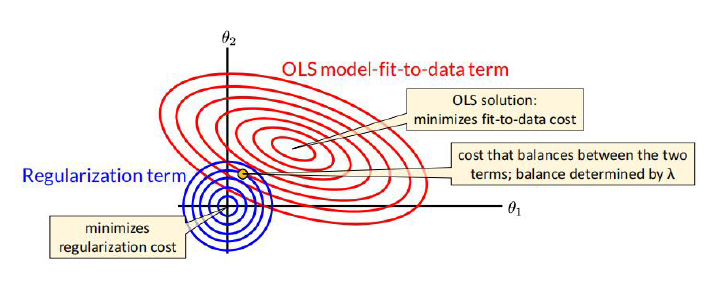

`sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, normalize='deprecated', copy_X=True, max_iter=None, tol=0.001, solver='auto', positive=False, random_state=None)`
- alpha 正则化力度
- solver{‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’ 会根据数据自动选择优化方法
- tol float, default=1e-3 算法的准确率精度
- max_iter int, default=None 最大迭代次数

[Ridge API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)

In [86]:
from sklearn.linear_model import Ridge

In [87]:
ridge = Ridge()
# param = {'alpha':[pow(10,i) for i in range(-5,2)],
#          'tol':[1e-3,1e-4,1e-5]}
param = {'alpha':np.arange(8.34,8.36,0.0001)}
gridsearch(10,ridge,param)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    8.3s


0.11316644922833402
Ridge(alpha=8.356599999999961)
{'alpha': 8.356599999999961}


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    9.4s finished


best_param = {'alpha': 8.356599999999961, 'tol': 0.001}

best_score = 0.11316644922833412

#### Lasso正则化(又称L1正则化)

- 代价函数：
    $$ Cost(W)= \frac{1}{m}\sum_{i=1}^{m}(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))^2+\lambda \sum_{j=1}^n ||w_j||$$
- 求解：</br>
    由于Lasso是非连续可导的，没法使用梯度下降法，一般使用坐标下降法、最小角回归法</br>
    这里尚未深入研究

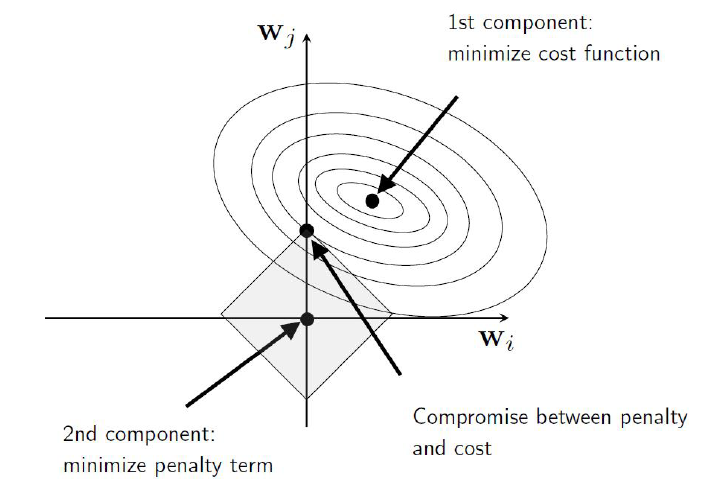

Lasso很容易受到异常值的影响</br>
若数据中存在很大的异常值，可能会影响特征的平均值和方差，影响标准化结果。在此种情况下，使用中位数和四分位数间距进行缩放会更有效。</br>

为了提升模型鲁棒性，引入RobustScaler
- RobustScaler:
    $$ x' = \frac{x - median}{IQR}$$(IQR为四分位距离)

`class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')`

[Lasso API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

In [87]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline,Pipeline

In [88]:
from sklearn.linear_model import Lasso

In [94]:
lassoRobust = Pipeline([
    ('robust',RobustScaler()),
    ('model',Lasso())
])
param = {'model__alpha':np.arange(3*1e-4,5*1e-4,1e-5).tolist(),
         'model__selection':['cyclic','random']}

In [92]:
gridsearch(10,lassoRobust,param)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   10.1s finished


0.1122320898068702
Pipeline(steps=[('robust', RobustScaler()),
                ('model',
                 Lasso(alpha=0.00035000000000000016, selection='random'))])
{'model__alpha': 0.00035000000000000016, 'model__selection': 'random'}


best_param ={'model__alpha': 0.00035000000000000016, 'model__selection': 'random', 'model__tol': 0.0001}

best_score = 0.1122320898068702

#### Elastic Net弹性网络

弹性网络相当于Ridge和Lasso的折中方法，通过r(mix ratio)混合比来进行控制:
- 代价函数：
    $$ Cost(W)= \frac{1}{m}\sum_{i=1}^{m}(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))^2 + r\lambda \sum_{j=1}^n ||w_j|| + (1-r) \lambda \sum_{j=1}^n w_j^2$$
    可见当r=0时，即为Ridge；r=1时，即为Lasso

`sklearn.linear_model.ElasticNet(alpha=1.0, *, l1_ratio=0.5, fit_intercept=True, normalize='deprecated', precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')`
- l1_ratio 即r

[ElasticNet API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet)

In [89]:
from sklearn.linear_model import ElasticNet

In [96]:
elasticRobust = Pipeline([
    ('robust',RobustScaler()),
    ('model',ElasticNet())
])
param = {'model__alpha':np.arange(1e-4,1e-2,0.001).tolist(),
         'model__selection':['cyclic','random'],
        'model__l1_ratio':np.arange(0.2,0.4,0.01).tolist()}

In [95]:
gridsearch(10,elasticRobust,param)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.8min finished


0.11240005410845215
Pipeline(steps=[('robust', RobustScaler()),
                ('model',
                 ElasticNet(alpha=0.0011, l1_ratio=0.3100000000000001))])
{'model__alpha': 0.0011, 'model__l1_ratio': 0.3100000000000001, 'model__selection': 'cyclic'}


best_param = {'model__alpha': 0.0011, 'model__l1_ratio': 0.3100000000000001, 'model__selection': 'cyclic'}

best_score = 0.11240005410845215

#### LinearSVR(线性支持向量回归)

其原理基本和做线性可分数据分类的SVM基本一致，其中的差别就是将分类间隔距离d换成了$\epsilon$,其意义是当回归误差$|y_i-\hat y_i|>\epsilon$的数据才计算其损失
- 代价函数：
    $$\min_{w,b}\frac{1}{2}||w||^2 + C\sum_{i=1}^{m}l_{\epsilon}(y_i-\hat y_{i_W}(x_1^i，x_2^i，...))$$
- 令:;
    $$z =y_i-\hat y_{i_W} $$
- 其中，$l_{\epsilon}$为：
    $$l_{\epsilon}(z)=
    \left\{\begin{matrix} 
     0,|z|<\epsilon \\
     |z|-\epsilon,otherwise 
    \end{matrix} 
    \right.$$
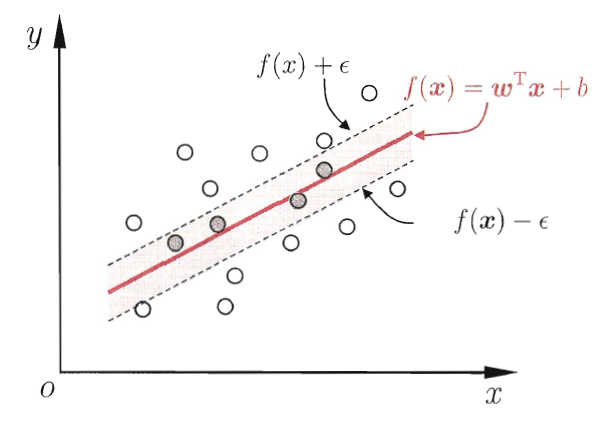

`sklearn.svm.LinearSVR(*, epsilon=0.0, tol=0.0001, C=1.0, loss='epsilon_insensitive', fit_intercept=True, intercept_scaling=1.0, dual=True, verbose=0, random_state=None, max_iter=1000)`

- epsilon 间隔
- C 正则化强度
[LinearSVR API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR)

In [90]:
from sklearn.svm import LinearSVR

In [210]:
linearSVR = LinearSVR()
# param = {'C':np.arange(0.2,0.4,0.01).tolist(),
#          'epsilon':np.arange(0,0.1,0.01).tolist(),
#         'loss':['epsilon_insensitive','squared_epsilon_insensitive']}
param = {'C':[0.3],
         'epsilon':np.arange(0,0.03,0.001).tolist(),
        'loss':['epsilon_insensitive','squared_epsilon_insensitive']}

In [110]:
gridsearch(10,linearSVR,param)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   38.4s finished


0.1440098304294076
LinearSVR(C=0.3, epsilon=0.001, loss='squared_epsilon_insensitive')
{'C': 0.3, 'epsilon': 0.001, 'loss': 'squared_epsilon_insensitive'}


E:\Anaconda\envs\mlearning\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


best_param ={'C': 0.3000000000000001, 'epsilon': 0.02, 'loss': 'epsilon_insensitive'}

best_score = 0.14060994704808424

### 考虑非线性映射,引入核函数

#### Kernel Ridge核岭回归

KRR的学习形式大体和SVR一致，但KRR直接用的就是平方差作为loss，而SVR则是基于$\epsilon$间隔

`sklearn.kernel_ridge.KernelRidge(alpha=1, *, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)`
- kernel
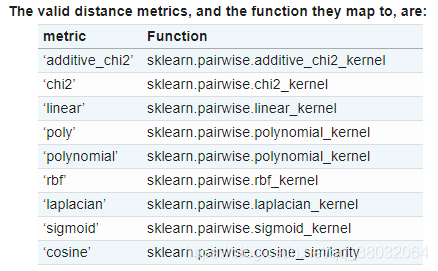

- gamma:</br>
    Gamma parameter for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels. Interpretation of the default value is left to the kernel; see the documentation for sklearn.metrics.pairwise. Ignored by other kernels.

这里就不使用了，直接看SVR

#### SVR支持向量机回归

`sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)`
- kernel:</br>
    {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
- gamma:</br>
    {‘scale’, ‘auto’} or float, default=’scale’
    在使用rbf、poly、sigmoid核函数时所需的参数
    - 取值为'scale'时：gamma=$\frac{1}{nfeatures*Var(X)}$
    - 取值为'auto'时：gamma=$\frac{1}{nfeatures}$

In [91]:
from sklearn.svm import SVR

In [100]:
kernelSVR=SVR()
# param = {'kernel':['poly','rbf'],
#         'C':[pow(10,i) for i in range(-2,5,2)]}
param = {'kernel':['poly','rbf'],
        'C':np.arange(8,9,0.01)}

In [101]:
gridsearch(10,kernelSVR,param)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.9min finished


0.11870737789329218
{'C': 8.809999999999983, 'kernel': 'rbf'}


best_param = {'C': 8.809999999999983, 'kernel': 'rbf'}

best_score = 0.11870737789329218

### 集成学习

**集成学习**利用了**群体智慧**的思想，少数人可能会基于各种因素错误率有差，但是对于事实是有正确主导观念的，因此当人多起来的时候，判断就逐渐变得可信和准确，因此可以将多个学习器进行组合来完成学习任务。</br>

举个例子，当每个分类器的正确率只有51%时，则利用集成学习中的投票法组合策略，1000个分类器结合准确率可达75%,10000个分类器结合将可达97%。</br>

当然以上情况是基于分类器是完全独立的前提，相互错误之间没有关系，然而对于现实中的任务来说这基本是不可能的，有的时候多数人错误一致的时候，所得准确率反而会下降。</br>

因此"**好而不同**"是集成学习所追求的情况，
- "好"保证个体学习器的学习能力不会太差
- "不同"保证个体学习器的多样性(diversity)。

根据学习器的组合方式不同可以分为"基学习算法"和"组件学习算法"(这里的名字有一定的主观元素)</br>
- 基学习算法：</br>
    使用的是同种类型的学习器，这样的集成称为"同质",其中每个学习器称为"基学习器"
- 组件学习算法：</br>
    使用的学习器器可以不相同，称为"异质"，每个学习器就称为"个体学习器"

#### 集成策略

集成策略是关于如何将多学习器结果进行结合的方法。</br>

常用的有三种：平均法、投票法、学习法。</br>
- 平均法：</br>
    平均法常用于处理数值型输出，分为简单平均和加权平均两种</br>
    - 简单平均：就是将多个学习器的输出结果求取均值</br>
        $$ Result = \frac{1}{T}\sum_{i=1}^{T}h_i{x} $$
        其中T为学习器的个数</br>
        
    - 加权平均：给多个学习器赋予对应的权重，并利用权重系数对结果进行加权平均
        $$ Result = \frac{1}{T}\sum_{i=1}^{T}w_i h_i{x} $$
        这里的权重$w_i$可以根据学习器的学习能力等因素来确定</br>
    
    
- 投票法(voting)：</br>
    投票法是面对分类任务的，根据多分类器的输出结果进行投票选择，一般可采取绝对多数投票法、加权投票法、相对多数投票法等。</br>
    
    投票法根据分类器输出结果为确定值和概率值分为硬投票和软投票。</br>
    - 硬投票：输出确定的类别
    - 软投票：输出各个类别的概率值</br>
</br>
- 学习法：</br>
    学习法是利用多分类器的输出结果来构建新的数据集，并用该数据集通过另一个学习器进行结合。这里个体学习器可以称为初级学习器，用于结合的学习器可以称为次级学习器或元学习器。</br>  
    </br>  
    Stacking(堆叠)是学习法的典型代表。</br> 
    </br>  
    其过程可如下图所示：首先构建n个model,对每一个model使用交叉验证，将每一轮交叉验证的验证结果作为次训练器的训练数据，将每一轮的交叉验证训练出来的模型的测试结果进行加和平均作为次训练器的标签，最终训练次机学习器。</br> 
    
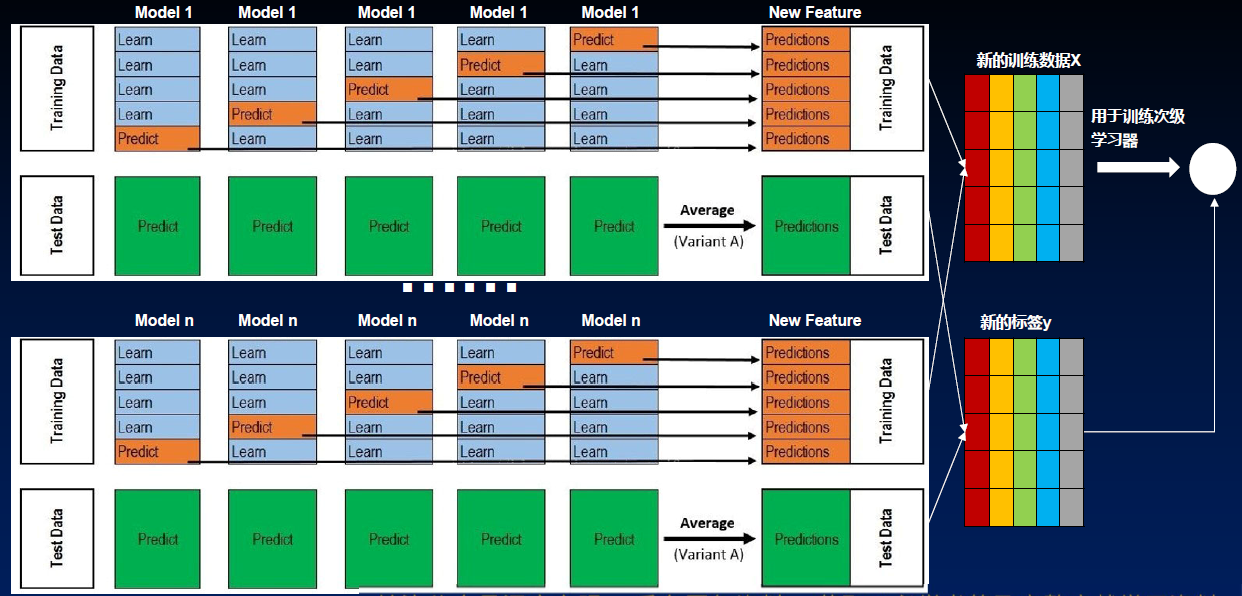

#### Bagging

Bagging是著名的集成学习方法之一，其相当于训练数据放在一个Bag里面，有多个学习器在里面抽取子数据集进行训练，将训练好的分类器用于测试数据，对各学习器结果进行结合得到最终的结果。

bagging采样时常用自助采样法，即有放回的随机采样。采样不放回的方法称为pasting。

bagging中使用的个体学习器是相同的，即基学习算法。
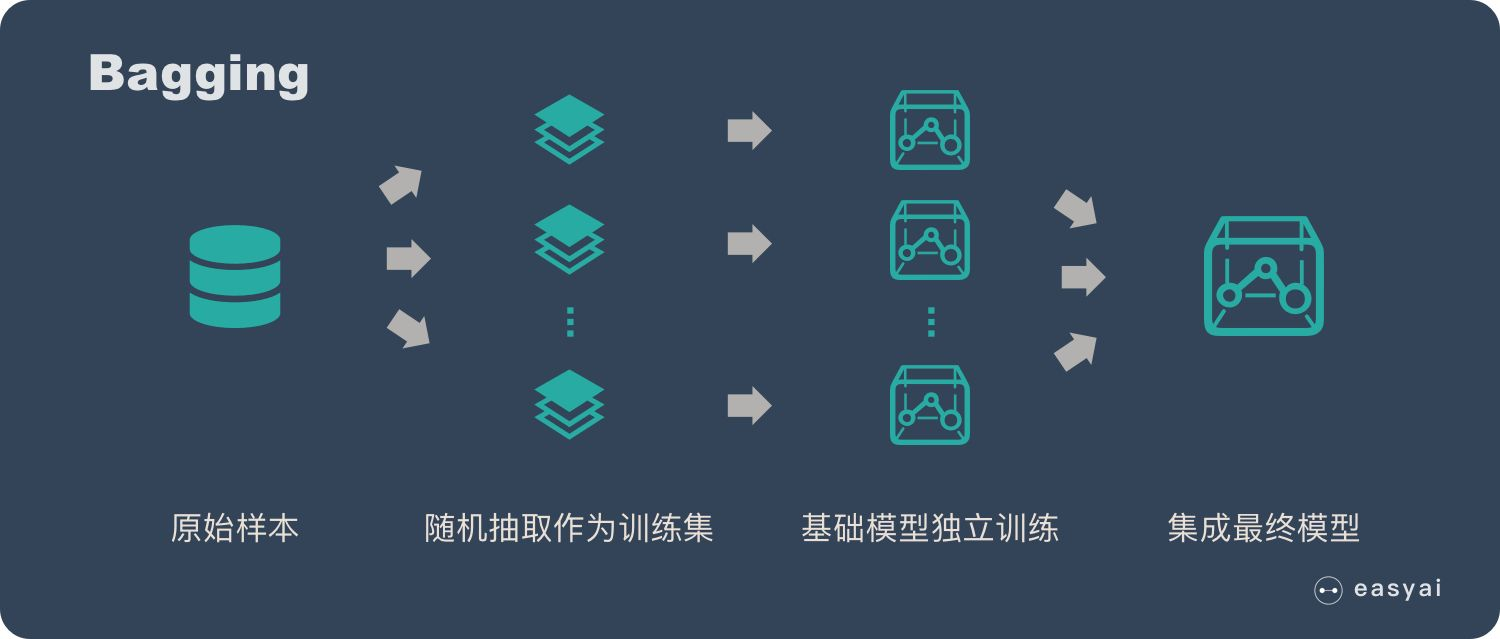

优点：
    由于每个学习器选择的数据并不完全相同，因此训练出来的整体模型泛化性能较强，同时使用的是有放回的自助采样法，能够保证个体学习器的学习性能。自主采样法还有一个好处是：所提取的训练数据为Bag数据的63.2%，则剩下的36.8%的样本可以作为验证集进行"out-of-bag estimate"(包外估计)。

`sklearn.ensemble.BaggingRegressor(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)`

- base_estimator default=DecisionTreeRegressor 基学习器，默认回归树
- n_estimators  default=10 学习器数量
- max_sample default=1.0 从训练数据抽取多少数据训练每一个基学习器
    - int 直接抽取 max_sample 个数据进行训练(代表个数)
    - float 抽取 max_sample*X.shape[0] 个数据进行过训练(代表占比)
- max_feature default=1.0 从训练数据中抽多少个特征进行训练
    - int 直接抽取 max_feature 个特征进行训练(代表个数)
    - float 抽取 max_feature*X.shape[1] 个特征进行过训练(代表占比)
- bootstrap bool, default=True 有放回还是无放回，默认有放回
- oob_score bool, default=False 是否采用包外估计，默认不采用

[BaggingRegressor API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)


In [92]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [93]:
baggingReg = BaggingRegressor()
param = {'base_estimator':[SVR(),DecisionTreeRegressor()],
        'n_estimators':[100,150,200],
        'oob_score':[True,False]}

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
def randomsearch(n_fold,n_iter,model,param={}):
    kfold = KFold(n_fold,shuffle=True,random_state=40).get_n_splits(x_train.values)
    rscv = RandomizedSearchCV(estimator=model,param_distributions=param,scoring='neg_mean_squared_error',cv=kfold,n_iter=n_iter,verbose=3,n_jobs=-1)
    rscv.fit(x_train.values,y_train)
    print(np.sqrt(-rscv.best_score_))
    print(rscv.best_estimator_)
    print(rscv.best_params_)

In [117]:
randomsearch(10,10,baggingReg,param)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


0.1335735072305748
BaggingRegressor(base_estimator=SVR(), n_estimators=150, oob_score=True)
{'oob_score': True, 'n_estimators': 150, 'base_estimator': SVR()}


best_params = {'oob_score': True, 'n_estimators': 150, 'base_estimator': SVR()}

best_score = 0.1335735072305748

#### RandomForest随机森林

RandomForest是Bagging的一个扩展变体，其实用的基学习器故名思意就是DecisionTree决策树，但于传统决策树不同，划分属性时不再是挑选最优属性，而是引入随机属性选择机制。这样做的优点是在bagging样本扰动的基础上，还添加上了属性扰动，使得学习器的多样性进一步增加，进而提高了泛化性能。

RandomForest在许多现实任务中都展现出强大的性能，被誉为"代表集成学习技术水平的方法"

`sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)`

- n_estimators int, default=100 决策树数目
- max_depth int, default=None 树的最大深度，如果为None，则分到所有叶子都是纯的，或者当叶子的样本小于min_samples_split
- min_samples_split int or float, default=2 进行划分的最小样本数
    - int 表示样本个数
    - float 则为ceil(min_samples_split*X.shape[0])
- min_samples_leaf int or float, default=1 叶子节点最小样本数，确定规则min_samples_split一致
- max_leaf_nodes: (default=None)最大叶子结点数
- max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto” 划分的最大特征数
- oob_score bool, default=False 包外估计
- max_samples int or float, default=None 训练每个学习器的最大样本数

[RandomForestRegressor API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
rf = RandomForestRegressor()
param = {'n_estimators':[800,1000,1200],
        'max_depth':[3,5,7],
        'max_features':['auto','sqrt'],
        'oob_score':[True,False],
        'min_samples_leaf':[10,20,30]}

In [127]:
randomsearch(10,10,rf,param)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


0.16548255407584817
RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=1000)
{'oob_score': False, 'n_estimators': 1000, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 7}


best_param = {'oob_score': False, 'n_estimators': 1200, 'min_samples_leaf': 10, 'max_depth': 20}

best_score = 0.14570026856767823

#### Boosting

Boosting是存在强依赖性、串行生成的序列化方法，能够将弱学习器逐步提升为强学习器。

其工作机制是，先初始化样本权重，并用初始数据训练出一个基学习器，再根据该学习器的表现来对训练样本的权重进行调整，使得分错的样本所占权重越大，同时该学习器的表现也将决定了它在结果结合过程中所占的比重，通过多次训练达到学习器数目阈值T后停止，最终模型结果将是各学习器结果的加权平均。

**Adaboost**

Adaboost是boosting家族中最为经典的一员了，其算法原理有多种推导方式，其中最容易理解的是加法模型

[详情见连接](https://www.cnblogs.com/pinard/p/6133937.html)

这里直接简述Adaboost的二分类和回归的算法流程：
- 二分类:

    1.初始化样本权重$D_1$
    $$D_1 = \{w_{11},w_{12},...,w_{1m}\}$$
    
    2.训练T个学习器(for k in 1,2,...,T):
   - 使用$D_k$和样本数据训练弱学习器$G_k(x)$
   
   - 计算$G_k(x)$的分类误差：
    $$e_k = \sum_{i=1}^{m}w_{ki}I(G_k(x_i)\neq y_i)$$
   - 计算弱分类器权重$a_k$
    $$a_k = \frac{1}{2}log\frac{1-e_k}{e_k}$$
   - 更新样本权重w_{k+1,i}
    $$w_{k+1,i} = \frac{w_{ki}e^{- a_k  y_i G_k(x_i)}}{Z_k}$$
    其中:
    $$Z_k = \sum_{i=1}^{m} w_{ki}e^{- a_k  y_i G_k(x_i)}$$
    
    3.最终分类器为：
    $$f(x) = sign(\sum_{k=1}^T a_kG_k(x))$$
    
- 回归:

    1.初始化样本权重$D_1$
    $$D_1 = \{w_{11},w_{12},...,w_{1m}\}$$
    
    2.训练T个学习器(for k in 1,2,...,T):
   - 使用$D_k$和样本数据训练弱学习器$G_k(x)$
   
   - 计算训练集上最大误差$E_k$
       $$E_k = max|y_i-G_k(x_i)|$$
   - 计算每个样本的相对误差(采用平方误差)
       $$e_{ki} = \frac{(y_i - G_k(x_i))^2}{E_k^2} $$
   - 计算回归误差率
       $$ e_k = \sum_{i=1}^{m}w_{ki}e_{ki}$$
   - 计算弱分类器权重$a_k$
       $$a_k = \frac{e_k}{1-e_k}$$
   - 更新样本权重w_{k+1,i}
       $$w_{k+1,i} = \frac{w_{ki}a_k^{1-e_{ki}}}{Z_k}$$
    其中:
    $$Z_k = \sum_{i=1}^{m} w_{ki}a_k^{1-e_{ki}}$$
    
    3.最终分类器为：
    $$f(x) = \sum_{k=1}^{T}(ln\frac{1}{a_k})g(x)$$
    其中，$g(x)$是所有$a_kG_k(x)$的中位数

`sklearn.ensemble.AdaBoostRegressor(base_estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)`

- base_estimator object, default=None</br>
 If None, then the base estimator is DecisionTreeRegressor initialized with max_depth=3.
- n_estimators int, default=50
- learning_rate float, default=1.0
- loss{‘linear’, ‘square’, ‘exponential’}, default=’linear’

[AdaBoostRegressor API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html?highlight=adaboost#sklearn.ensemble.AdaBoostRegressor)

In [98]:
from sklearn.ensemble import AdaBoostRegressor

In [99]:
ada = AdaBoostRegressor()
param = {'base_estimator':[DecisionTreeRegressor(),SVR()],
        'n_estimators':[100,200,400],
        'loss':['linear','square'],
        'learning_rate':[0.8,1]}

In [164]:
evaluate_model(10,ada)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.2s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


array([0.1684758 , 0.16926112, 0.15888784, 0.16707019, 0.1880277 ,
       0.15742988, 0.17069178, 0.15906484, 0.17202767, 0.17687814])

**GBDT**

要理解XGBoost可能得先理解GBDT(Gradient Boosting Decision Tree，简称梯度提升树)，它结合了回归树和梯度提升的思想。

- CART回归树:不同于分类树使用熵或基尼系数来衡量划分点，而是使用平方误差衡量

- Boosting Tree提升树:</br>
    其思想计算每一个模型输出的残差并用下一个模型去拟合该残差，最终得到的结果是每个模型的输出总和。
    - 过程如下：</br>
        1.初始化$f_0(x)=0$</br>
        2.训练T个训练器(for k in 1,2,...,T)
        - 计算残差项：</br>
        $$r_{ki} = y_i - f_{m-1}(x)$$
        - 学习一个回归树$t_k(x)$来拟合残差
        - 更新
        $$f_k(x) = f_{m-1}(x)+t_k(x)$$
        3.得到的提升树模型：
        $$f(x)=\sum_{k=1}^{T}t_k(x)$$
    这里损失函数可以使用平方误差，对应的残差就可以定义为模型输出与目标值的差了

但对于一般的损失函数而言，定义残差似乎不是件简单的事情，Friedman提出了使用梯度提升树算法，使用损失函数的负梯度作为提升树算法的残差近似值

GBDT算法流程：
- 初始化弱学习器
    $$f_0(x) = argmin_c\sum_{i=1}^{m}L(y_i,c)$$
- 构建T个学习器(for k in 1,2,..,T):
    - 计算残差，即负梯度
        $$r_{ki}=-[\frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}]_{f(x) = f_{k-1}(x)}$$
    - 将该残差作为下一棵树的样本真实值，得到以一棵新的回归树$f_k(x)$和器对应的叶子节点区域$R_{kj}(j为f_k的叶子节点个数)$
    - 对叶子区域计算最佳拟合值
        $$g_{kj} = argmin_g \sum_{x_i \in R_{kj} }L(y_i,f_{k-1}(x_i)+g)$$
    - 更新强学习器
        $$f_k(x) = f_{k-1}(x) + \sum_{j=1}^{J}g_{kj}I(x\in R_{kj})$$
- 最终的学习器
    $$f(x)=f_0(x) + \sum_{k=1}^{T}\sum_{j=1}^{J}g_{kj}I(x\in R_{kj})$$

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

In [221]:
gbdt = GradientBoostingRegressor()
score = evaluate_model(10,gbdt)
np.mean(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.2s


KeyboardInterrupt: 

**XGBoost**

- 损失函数：
    $$ J(f_k) = \sum_{i=1}^{m}L(y_i,\hat y_i^{t-1} + f_k(x_i))+\Omega(f_t)+C$$
- 正则项：
    $$ \Omega(f)=\gamma T+\frac{1}{2}\lambda||w||^2$$
- 求解后带回目标函数得到打分函数：
    $$obj^* = -\frac{1}{2}\sum_{j=1}^{T}\frac{G_j^2}{H_j+\lambda}+\gamma T$$
  其中$G_j$是一阶导的和，$H_j$是二阶导的和

[推导](https://zhuanlan.zhihu.com/p/83901304)

In [101]:
import xgboost as xgb

In [102]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [186]:
score = evaluate_model(10,model_xgb)
np.mean(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   18.6s remaining:   43.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.6s finished


0.11281531303499685

**LightGBM**

In [103]:
import lightgbm as lgb

In [104]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [188]:
score = evaluate_model(10,model_lgb)
np.mean(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


0.11390050769086897

#### 结合

**平均加权**

In [105]:
from sklearn.base import BaseEstimator,RegressorMixin,clone

In [106]:
class AverageWeight(BaseEstimator,RegressorMixin):
    def __init__(self,model,weight):
        self.model = model
        self.weight = weight
    def fit(self,X,y):
        self.mod_ = [clone(x) for x in self.model]
        for model in self.mod_:
            model.fit(X,y)
        return self
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.mod_])
        for i in range(pred.shape[1]):
                single = [pred[model,i]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
                w.append(np.sum(single))
        return w

In [107]:
weight = np.array([0.11316644922833402,0.1122320898068702,0.11240005410845215
,0.11870737789329218])
weight = weight/np.sum(weight)
weight

array([0.24789697, 0.24585021, 0.24621815, 0.26003467])

In [108]:
ridge = Ridge(alpha=8.356599999999961)
lassoRobust = Pipeline([
    ('robust',RobustScaler()),
    ('model',Lasso(alpha=0.00035000000000000016, selection='random'))
])
elasticRobust = Pipeline([
    ('robust',RobustScaler()),
    ('model',ElasticNet(alpha=0.0011, l1_ratio=0.3100000000000001,selection='cyclic'))
])
kernelSVR=SVR(C=8.809999999999983, kernel='rbf')

In [105]:
# aver_model = AverageWeight([ridge,lassoRobust,elasticRobust,kernelSVR],weight)
# aver_model.fit(x_train,y_train)
# y_pre = aver_model.predict(x_train)

In [109]:
aver_model = AverageWeight([ridge,lassoRobust,elasticRobust,kernelSVR],weight)
score = evaluate_model(10,aver_model)
np.mean(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


0.11074910046703704

**Stacking**

待学习

**BigBoss**

In [110]:
def rmse(y_true,y_pre):
    return (np.sqrt(mean_squared_error(y_true=y_true,y_pred=y_pre)))

In [111]:
model_xgb.fit(x_train,y_train)
model_lgb.fit(x_train,y_train)
aver_model.fit(x_train,y_train)
y_pre1 = model_xgb.predict(x_train).reshape(-1,1)
y_pre2 = model_lgb.predict(x_train).reshape(-1,1)
y_pre3 = np.array(aver_model.predict(x_train)).reshape(-1,1)
print('xgb:',rmse(y_train,y_pre1))
print('lgb:',rmse(y_train,y_pre2))
print('averge:',rmse(y_train,y_pre3))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
xgb: 0.07961959039431687
lgb: 0.07316671490659704
averge: 0.09584493938341468


In [112]:
weight = np.array([1/0.07961959039431687,1/0.07316671490659704,1/0.10003043698260074])
weight = weight/np.sum(weight)
weight

array([0.34672287, 0.3773018 , 0.27597533])

In [113]:
y_pre1 = model_xgb.predict(x_test).reshape(-1,1)
y_pre2 = model_lgb.predict(x_test).reshape(-1,1)
y_pre3 = np.array(aver_model.predict(x_test)).reshape(-1,1)

In [114]:
y_pre = y_pre1*weight[0]+y_pre2*weight[1]+y_pre3*weight[2]

In [115]:
y_pre = np.exp(y_pre)

In [119]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = np.exp(y_pre1)
sub.to_csv('submission3.csv',index=False)

## 结果不是很好，权当学习了

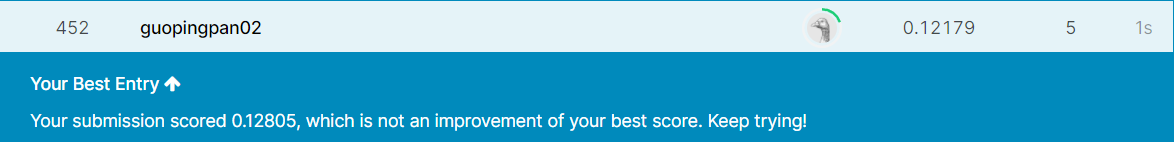